Todo:
- build token-level df; sample on this level rather than on type level and then subsequently on token level. OR support both.
- support cross product comparison within experiment. e.g. group by inflection and run behavioral evaluation on all pairs of post-divergence options
- counterfactual false friends
- run for all models

In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
from collections import defaultdict, Counter
import functools
import itertools
from pathlib import Path
import pickle
import re

from fastdist import fastdist
import lemminflect
import matplotlib.pyplot as plt
from matplotlib import transforms
import nltk
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import seaborn as sns
import torch
from tqdm import tqdm

from src.analysis import analogy
from src.analysis.state_space import StateSpaceAnalysisSpec, \
    prepare_state_trajectory, aggregate_state_trajectory, flatten_trajectory
from src.datasets.speech_equivalence import SpeechEquivalenceDataset

In [3]:
base_model = "w2v2_8"

model_class = "discrim-rnn_32-mAP1"
model_name = "word_broad_10frames_fixedlen25"

# model_class = "ff_32"
# model_name = "word_broad_10frames"

train_dataset = "librispeech-train-clean-100"
model_dir = f"outputs/models/{train_dataset}/{base_model}/{model_class}/{model_name}"
output_dir = f"."
dataset_path = f"outputs/preprocessed_data/{train_dataset}"
equivalence_path = f"outputs/equivalence_datasets/{train_dataset}/{base_model}/{model_name}/equivalence.pkl"
hidden_states_path = f"outputs/hidden_states/{train_dataset}/{base_model}/{train_dataset}.h5"
state_space_specs_path = f"outputs/state_space_specs/{train_dataset}/{base_model}/state_space_specs.h5"
embeddings_path = f"outputs/model_embeddings/{train_dataset}/{base_model}/{model_class}/{model_name}/{train_dataset}.npy"

pos_counts_path = "data/pos_counts.pkl"

seed = 1234

max_samples_per_word = 100

metric = "cosine"

agg_fns = [
    "mean",
]

In [50]:
with open(embeddings_path, "rb") as f:
    model_representations: np.ndarray = np.load(f)
state_space_spec = StateSpaceAnalysisSpec.from_hdf5(state_space_specs_path, "word")
assert state_space_spec.is_compatible_with(model_representations)

In [51]:
# model_representations /= np.linalg.norm(model_representations, axis=1, keepdims=True)

In [52]:
state_space_spec = state_space_spec.subsample_instances(max_samples_per_word)

In [53]:
trajectory = prepare_state_trajectory(model_representations, state_space_spec, pad=np.nan)

In [54]:
trajectory_aggs = {agg_fn: aggregate_state_trajectory(trajectory, state_space_spec, agg_fn, keepdims=True)
                   for agg_fn in tqdm(agg_fns)}

  0%|          | 0/1 [00:00<?, ?it/s]

Aggregating:   0%|          | 0/32046 [00:00<?, ?label/s]

In [55]:
trajectory_aggs_flat = {k: flatten_trajectory(v) for k, v in trajectory_aggs.items()}

In [56]:
agg, agg_src = trajectory_aggs_flat["mean"]

In [57]:
cuts_df = state_space_spec.cuts.xs("phoneme", level="level").drop(columns=["onset_frame_idx", "offset_frame_idx"])
cuts_df["label_idx"] = cuts_df.index.get_level_values("label").map({l: i for i, l in enumerate(state_space_spec.labels)})
cuts_df["frame_idx"] = cuts_df.groupby(["label", "instance_idx"]).cumcount()
cuts_df = cuts_df.reset_index().set_index(["label", "instance_idx", "frame_idx"]).sort_index()

description  item_idx  label_idx
label   instance_idx frame_idx                                 
a       0            0                  AH      1840         15
        1            0                  AH      1169         15
        2            0                  AH      2403         15
        3            0                  AH       177         15
        4            0                  AH     18393         15
...                                    ...       ...        ...
zverkov 15           1                   V     15117      24522
                     2                  ER     15117      24522
                     3                   K     15117      24522
                     4                  AO     15117      24522
                     5                   V     15117      24522

[1778852 rows x 3 columns]

In [58]:
cut_phonemic_forms = cuts_df.groupby(["label", "instance_idx"]).description.agg(' '.join)

label    instance_idx
a        0                          AH
         1                          AH
         2                          AH
         3                          AH
         4                          AH
                             ...      
zverkov  11              Z V ER K AO V
         12              Z V ER K AO V
         13              Z V ER K AO V
         14              Z V ER K AO V
         15              Z V ER K AO V
Name: description, Length: 334008, dtype: object

In [59]:
with open(pos_counts_path, "rb") as f:
    pos_counts = pickle.load(f)

## Experiment setup

In [60]:
inflection_targets = [
    "VBD",
    "VBZ",
    "VBG",
    "NNS",
    "NOT-latin",
]
labels = state_space_spec.label_counts
labels = set(labels[labels > 5].index)

inflection_results_df = analogy.get_inflection_df(
    inflection_targets, labels)
inflection_results_df["base_idx"] = inflection_results_df.base.map({l: i for i, l in enumerate(state_space_spec.labels)})
inflection_results_df["inflected_idx"] = inflection_results_df.inflected.map({l: i for i, l in enumerate(state_space_spec.labels)})
inflection_results_df

,inflected,base,is_regular,base_idx,inflected_idx
inflection,,,,,
VBD,rejected,reject,True,11149,16003
VBD,explored,explore,True,5468,5461
VBD,scared,scare,True,9023,1996
VBD,opened,open,True,2110,741
VBD,developed,develop,True,7843,4941
...,...,...,...,...,...
NOT-latin,insignificant,significant,True,6637,3014
NOT-latin,indisposed,disposed,True,7769,5201
NOT-latin,inconvenience,convenience,True,5143,6538


In [61]:
# Add on random word pair baseline
num_random_word_pairs = inflection_results_df.groupby("inflection").size().max()
random_word_pairs = np.random.choice(len(list(labels)), size=(num_random_word_pairs, 2))
random_word_pairs = pd.DataFrame(random_word_pairs, columns=["base_idx", "inflected_idx"])
random_word_pairs["base"] = random_word_pairs.base_idx.map({i: l for i, l in enumerate(state_space_spec.labels)})
random_word_pairs["inflected"] = random_word_pairs.inflected_idx.map({i: l for i, l in enumerate(state_space_spec.labels)})
random_word_pairs["is_regular"] = False
random_word_pairs["inflection"] = "random"
random_word_pairs = random_word_pairs.set_index("inflection")
random_word_pairs

,base_idx,inflected_idx,base,inflected,is_regular
inflection,,,,,
random,10222,9462,lip,w,False
random,8593,6530,misdirected,paused,False
random,5063,3611,joke,dozen,False
random,2508,7967,gravely,swoon,False
random,3653,6866,chester,luther,False
...,...,...,...,...,...
random,6209,8263,beryls,railroad,False
random,4831,1164,spare,business,False
random,10311,5971,earthly,obligation,False


In [62]:
inflection_results_df = pd.concat([inflection_results_df, random_word_pairs])

### Pre-compute other auxiliary features

In [63]:
def is_noun_ambiguous(row):
    attested_pos = set(pos_counts[row.base].keys()) | set(pos_counts[row.inflected].keys())
    return len(attested_pos & {"VERB"}) > 0
inflection_results_df.loc["NNS", "base_ambig_NN_VB"] = inflection_results_df.loc["NNS"].apply(is_noun_ambiguous, axis=1)
inflection_results_df.loc["NNS"].groupby("base_ambig_NN_VB").sample(10)

,inflected,base,is_regular,base_idx,inflected_idx,base_ambig_NN_VB
inflection,,,,,,
NNS,failures,failure,True,6727,6487,False
NNS,plates,plate,True,3280,9420,False
NNS,sentinels,sentinel,True,20317,15022,False
NNS,princes,prince,True,1135,1589,False
NNS,branches,branch,True,8959,2849,False
NNS,pistols,pistol,True,2178,1669,False
NNS,characters,character,True,1553,4054,False
NNS,strokes,stroke,True,5630,7736,False
NNS,servants,servant,True,8261,3032,False


In [64]:
def is_verb_ambiguous(row):
    attested_pos = set(pos_counts[row.base].keys()) | set(pos_counts[row.inflected].keys())
    return len(attested_pos & {"NOUN"}) > 0
inflection_results_df.loc["VBZ", "base_ambig_NN_VB"] = inflection_results_df.loc["VBZ"].apply(is_verb_ambiguous, axis=1)
inflection_results_df.loc["VBZ"].groupby("base_ambig_NN_VB").sample(10)

,inflected,base,is_regular,base_idx,inflected_idx,base_ambig_NN_VB
inflection,,,,,,
VBZ,forwards,forward,True,718,5944,False
VBZ,becomes,become,True,2494,5688,False
VBZ,continues,continue,True,1919,7239,False
VBZ,suggests,suggest,True,9972,4545,False
VBZ,owes,owe,True,3217,6074,False
VBZ,occurs,occur,True,8608,8651,False
VBZ,arises,arise,True,7471,12484,False
VBZ,meets,meet,True,1101,10640,False
VBZ,begins,begin,True,2052,4634,False


### Token-level features

#### Post-divergence analysis

In [65]:
@functools.lru_cache
def _get_base_forms(base_label: str) -> frozenset[tuple[str, ...]]:
    base_cuts = cuts_df.loc[base_label]
    base_phon_forms = frozenset(base_cuts.groupby("instance_idx").apply(
        lambda xs: tuple(xs.description)))
    return base_phon_forms

In [66]:
@functools.lru_cache
def _get_phonological_divergence(base_forms: frozenset[tuple[str, ...]],
                                 inflected_form: tuple[str, ...]) -> tuple[int, tuple[str, ...]]:
    phono_divergence_points = []
    for base_phones in base_forms:
        for idx in range(len(inflected_form) + 1):
            if inflected_form[:idx] != base_phones[:idx]:
                break
        phono_divergence_points.append(idx - 1)
    phono_divergence_point = max(phono_divergence_points)

    post_divergence = inflected_form[phono_divergence_point:]
    return phono_divergence_point, post_divergence

In [67]:
def get_phonological_divergence(base_label, inflected_label, inflected_instance_idx):
    try:
        base_phon_forms = _get_base_forms(base_label)
        inflected_phones = tuple(cuts_df.loc[inflected_label].loc[inflected_instance_idx].description)
    except KeyError:
        return Counter()

    div_point, div_content = _get_phonological_divergence(base_phon_forms, inflected_phones)
    return inflected_phones, div_content

In [125]:
inflection_instances = []

for inflection, row in tqdm(inflection_results_df.iterrows(), total=len(inflection_results_df)):
    inflected_flat_idxs = np.nonzero(agg_src[:, 0] == row.inflected_idx)[0]
    for flat_idx in inflected_flat_idxs:
        inflected_instance_idx = agg_src[flat_idx, 1]
        inflected_phones, post_divergence = \
            get_phonological_divergence(row.base, row.inflected, inflected_instance_idx)
        
        inflected_phones = " ".join(inflected_phones)
        post_divergence = " ".join(post_divergence)
        inflection_instances.append({
            "inflection": inflection,
            "base": row.base,
            "inflected": row.inflected,
            "inflected_instance_idx": inflected_instance_idx,
            "inflected_phones": inflected_phones,
            "post_divergence": post_divergence,
        })

  0%|          | 0/4632 [00:00<?, ?it/s]

In [126]:
inflection_instance_df = pd.DataFrame(inflection_instances)

# Now merge with type-level information.
inflection_instance_df = pd.merge(inflection_instance_df,
                                  inflection_results_df.reset_index(),
                                  how="left",
                                  on=["inflection", "base", "inflected"])
inflection_instance_df

,inflection,base,inflected,inflected_instance_idx,inflected_phones,post_divergence,is_regular,base_idx,inflected_idx,base_ambig_NN_VB
0,VBD,reject,rejected,0,R IH JH EH K T IH D,IH D,True,11149,16003,NaN
1,VBD,reject,rejected,1,R IY JH EH K T IH D,IH D,True,11149,16003,NaN
2,VBD,reject,rejected,2,R IY JH EH K T IH D,IH D,True,11149,16003,NaN
3,VBD,reject,rejected,3,R IH JH EH K T IH D,IH D,True,11149,16003,NaN
4,VBD,reject,rejected,4,R IH JH EH K T IH D,IH D,True,11149,16003,NaN
...,...,...,...,...,...,...,...,...,...,...
121156,random,whittled,hosts,8,HH OW S T S,HH OW S T S,False,9033,323,NaN
121157,random,whittled,hosts,9,HH OW S T S,HH OW S T S,False,9033,323,NaN
121158,random,whittled,hosts,10,HH OW S T S,HH OW S T S,False,9033,323,NaN
121159,random,whittled,hosts,11,HH OW S T S,HH OW S T S,False,9033,323,NaN


In [224]:
# return most-common-allomorph information to main df
# NB this may collapse across different orthographic inflected forms
most_common_allomorphs = inflection_instance_df.groupby(["inflection", "base"]).post_divergence \
    .apply(lambda xs: xs.value_counts().idxmax()) \
    .rename("most_common_allomorph").reset_index()
pd.merge(inflection_results_df, most_common_allomorphs,
         on=["inflection", "base"], validate="m:1")

,inflection,inflected,base,is_regular,base_idx,inflected_idx,base_ambig_NN_VB,most_common_allomorph
0,VBD,rejected,reject,True,11149,16003,NaN,IH D
1,VBD,explored,explore,True,5468,5461,NaN,D
2,VBD,scared,scare,True,9023,1996,NaN,D
3,VBD,opened,open,True,2110,741,NaN,D
4,VBD,developed,develop,True,7843,4941,NaN,T
...,...,...,...,...,...,...,...,...
4627,random,railroad,beryls,False,6209,8263,NaN,R EY L R OW D
4628,random,business,spare,False,4831,1164,NaN,B IH Z N AH S
4629,random,obligation,earthly,False,10311,5971,NaN,AA B L AH G EY SH AH N
4630,random,skilled,vastness,False,8079,9403,NaN,S K IH L D


In [71]:
inflection_cross_instances = []
base_cross_instances = []

for inflection, row in tqdm(inflection_results_df.iterrows(), total=len(inflection_results_df)):
    inflected_flat_idxs = np.nonzero(agg_src[:, 0] == row.inflected_idx)[0]
    inflected_forms = cut_phonemic_forms.loc[row.inflected]
    for inflected_flat_idx in inflected_flat_idxs:
        inflected_instance_idx = agg_src[inflected_flat_idx, 1]
        inflection_cross_instances.append({
            "inflection": inflection,
            "base": row.base,
            "inflected": row.inflected,
            "inflected_instance_idx": inflected_instance_idx,
            "inflected_phones": inflected_forms.loc[inflected_instance_idx]
        })

    base_flat_idxs = np.nonzero(agg_src[:, 0] == row.base_idx)[0]
    base_forms = cut_phonemic_forms.loc[row.base]
    for base_flat_idx in base_flat_idxs:
        base_instance_idx = agg_src[base_flat_idx, 1]
        base_cross_instances.append({
            "inflection": inflection,
            "base": row.base,
            "inflected": row.inflected,
            "base_instance_idx": base_instance_idx,
            "base_phones": base_forms.loc[base_instance_idx]
        })

  0%|          | 0/4632 [00:00<?, ?it/s]

In [131]:
# add in post-divergence information
inflection_cross_instances_df = pd.DataFrame(inflection_cross_instances)
merge_on = ["inflection", "base", "inflected", "inflected_instance_idx"]
inflection_cross_instances_df = pd.merge(inflection_cross_instances_df,
                                         inflection_instance_df[merge_on + ["post_divergence"]],
                                         on=merge_on)

all_cross_instances = pd.merge(pd.DataFrame(base_cross_instances),
         inflection_cross_instances_df,
         on=["inflection", "base", "inflected"],
         how="outer")

# Now merge with type-level information.
all_cross_instances = pd.merge(inflection_results_df.reset_index(),
                               all_cross_instances,
                               on=["inflection", "base", "inflected"],
                               validate="1:m")

all_cross_instances["exclude_main"] = False
all_cross_instances

,inflection,inflected,base,is_regular,base_idx,inflected_idx,base_ambig_NN_VB,base_instance_idx,base_phones,inflected_instance_idx,inflected_phones,post_divergence,exclude_main
0,VBD,rejected,reject,True,11149,16003,NaN,0,R IH JH EH K T,0,R IH JH EH K T IH D,IH D,False
1,VBD,rejected,reject,True,11149,16003,NaN,0,R IH JH EH K T,1,R IY JH EH K T IH D,IH D,False
2,VBD,rejected,reject,True,11149,16003,NaN,0,R IH JH EH K T,2,R IY JH EH K T IH D,IH D,False
3,VBD,rejected,reject,True,11149,16003,NaN,0,R IH JH EH K T,3,R IH JH EH K T IH D,IH D,False
4,VBD,rejected,reject,True,11149,16003,NaN,0,R IH JH EH K T,4,R IH JH EH K T IH D,IH D,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6598225,random,hosts,whittled,False,9033,323,NaN,1,W IH T AH L D,8,HH OW S T S,HH OW S T S,False
6598226,random,hosts,whittled,False,9033,323,NaN,1,W IH T AH L D,9,HH OW S T S,HH OW S T S,False
6598227,random,hosts,whittled,False,9033,323,NaN,1,W IH T AH L D,10,HH OW S T S,HH OW S T S,False
6598228,random,hosts,whittled,False,9033,323,NaN,1,W IH T AH L D,11,HH OW S T S,HH OW S T S,False


### Add false friends

In [ ]:
def compute_false_friends():
    false_friends_dfs = {}
    inflection_allomorph_grouper = most_common_allomorphs \
        [~most_common_allomorphs.inflection.isin(("random", "NOT-latin"))] \
        .groupby("inflection").most_common_allomorph \
        .apply(lambda xs: xs.value_counts()[:3]).index
    for inflection, post_divergence in tqdm(inflection_allomorph_grouper):
        avoid_inflections = {"POS", inflection}
        if inflection == "NNS":
            avoid_inflections.add("VBZ")
        elif inflection == "VBZ":
            avoid_inflections.add("NNS")
        avoid_inflections = list(avoid_inflections)

        try:
            false_friends_dfs[inflection, post_divergence] = \
                analogy.prepare_false_friends(
                    inflection_results_df,
                    inflection_instance_df,
                    cut_phonemic_forms,
                    post_divergence,
                    avoid_inflections=avoid_inflections)
        except:
            print("Failed for", inflection, post_divergence)
            continue

    return false_friends_dfs

false_friends_cache_path = Path(output_dir) / "false_friends.pt"
if false_friends_cache_path.exists():
    false_friends_dfs = torch.load(false_friends_cache_path)
else:
    false_friends_dfs = compute_false_friends()
    torch.save(false_friends_dfs, false_friends_cache_path)

  0%|          | 0/12 [00:00<?, ?it/s]

In [203]:
false_friends_df = pd.concat(false_friends_dfs, names=["inflection", "post_divergence"]).droplevel(-1)

# manually exclude some cases that don't get filtered out, often just because they're too
# low frequency for both true base and inflected form to appear

# share exclusion list for NNS and VBZ since we have experiments relating these two
# so this is any false-friend for which their is a phonologically identical "base"
# that could instantiate a VBZ or NNS inflection
exclude_NNS_VBZ = ("adds americans arabs assyrians berries carlyle's childs christians "
                   "counties cruise dares dealings delawares europeans excellencies "
                   "fins fours galleries gaze germans indians isles maids mary's negroes "
                   "nuns peas phrase pyes reflections rodgers romans russians simpsons "
                   "spaniards sundays vickers weeds wigwams williams "
                   "jews odds news "
                    
                   "greeks lapse mix philips trunks its "
                    
                   "breeches occurrences personages").split()
false_friends_manual_exclude = {
    "NNS": exclude_NNS_VBZ,
    "VBZ": exclude_NNS_VBZ,
    "VBD": ("armored bald bard counseled crude dared enquired healed knowed legged "
            "mourned natured renowned rude second ward wild willed withered "

            "tract wrapped fitted hearted heralded intrusted knitted wretched").split(),
    "VBG": ("ceiling daring fleeting morning roaming wasting weaving weighing "
            "whining willing chuckling kneeling sparkling startling").split()
}

false_friends_df = false_friends_df.groupby("inflection", as_index=False).apply(
    lambda xs: xs[~xs.inflected.isin(false_friends_manual_exclude.get(xs.name, []))]).droplevel(0)

# exclude the (quite interesting) cases where the "base" and "inflected" form are
# actually orthographically matched, and we're seeing the divergence due to a pronunciation
# variant (e.g. don't as D OW N vs D O WN T)
false_friends_df = false_friends_df[false_friends_df.base != false_friends_df.inflected]

false_friends_df

base         base_form   inflected  \
inflection post_divergence                                            
NNS        Z                     adam         AE D AH M       adams   
           Z                afterward  AE F T ER W ER D  afterwards   
           Z                       an              AE N      anne's   
           Z                       eh                EH          as   
           Z                 backward     B AE K W ER D   backwards   
...                               ...               ...         ...   
VBZ        S                     when            W EH N      whence   
           S                     when         HH W EH N      whence   
           S                    we're              W ER       worse   
           S                       ye              Y EH         yes   
           IH Z                  rich           R IH CH      riches   

                                inflected_form  
inflection post_divergence                      
NNS        Z                       AE D AH M Z  
           Z                AE F T ER W ER D Z  
           Z                            AE N Z  
           Z                              EH Z  
           Z                   B AE K W ER D Z  
...                                        ...  
VBZ        S                          W EH N S  
           S                       HH W EH N S  
           S                            W ER S  
           S                            Y EH S  
           IH Z                   R IH CH IH Z  

[294 rows x 4 columns]

In [75]:
cross_false_friends_df = pd.merge(false_friends_df.reset_index(),
         cut_phonemic_forms.reset_index().rename(
             columns={"label": "base", "description": "base_form",
                      "instance_idx": "base_instance_idx"}),
         on=["base", "base_form"], how="left")
cross_false_friends_df = pd.merge(cross_false_friends_df,
         cut_phonemic_forms.reset_index().rename(
             columns={"label": "inflected", "description": "inflected_form",
                      "instance_idx": "inflected_instance_idx"}),
         on=["inflected", "inflected_form"], how="left")

# update to match all_cross_instances schema
cross_false_friends_df = cross_false_friends_df.rename(
    columns={"base_form": "base_phones",
             "inflected_form": "inflected_phones"})
cross_false_friends_df["base_idx"] = cross_false_friends_df.base.map({l: i for i, l in enumerate(state_space_spec.labels)})
cross_false_friends_df["inflected_idx"] = cross_false_friends_df.inflected.map({l: i for i, l in enumerate(state_space_spec.labels)})
cross_false_friends_df["is_regular"] = True

cross_false_friends_df["inflection"] = (cross_false_friends_df.inflection + "-FF-").str.cat(cross_false_friends_df.post_divergence, sep="")
cross_false_friends_df["exclude_main"] = True
cross_false_friends_df

,inflection,post_divergence,base,base_phones,inflected,inflected_phones,base_instance_idx,inflected_instance_idx,base_idx,inflected_idx,is_regular,exclude_main
0,NNS-FF-S,S,barbara,B AA R B ER AH,barbarous,B AA R B ER AH S,4,0,3271,1759,True,True
1,NNS-FF-S,S,barbara,B AA R B ER AH,barbarous,B AA R B ER AH S,4,1,3271,1759,True,True
2,NNS-FF-S,S,barbara,B AA R B ER AH,barbarous,B AA R B ER AH S,4,2,3271,1759,True,True
3,NNS-FF-S,S,barbara,B AA R B ER AH,barbarous,B AA R B ER AH S,4,3,3271,1759,True,True
4,NNS-FF-S,S,barbara,B AA R B ER AH,barbarous,B AA R B ER AH S,4,4,3271,1759,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
383962,VBZ-FF-IH Z,IH Z,rich,R IH CH,riches,R IH CH IH Z,99,14,2806,4671,True,True
383963,VBZ-FF-IH Z,IH Z,rich,R IH CH,riches,R IH CH IH Z,99,15,2806,4671,True,True
383964,VBZ-FF-IH Z,IH Z,rich,R IH CH,riches,R IH CH IH Z,99,16,2806,4671,True,True
383965,VBZ-FF-IH Z,IH Z,rich,R IH CH,riches,R IH CH IH Z,99,17,2806,4671,True,True


In [133]:
all_cross_instances = pd.concat([all_cross_instances, cross_false_friends_df], axis=0)

## Behavioral tests

In [340]:
# general queries for all experiments to exclude special edge cases;
# logic doesn't make sense in most experiments
all_query = "not exclude_main"

experiments = {
    "basic": {
        "group_by": ["inflection"],
        "all_query": all_query,
    },
    "regular": {
        "group_by": ["inflection", "is_regular"],
        "all_query": all_query,
    },
    # "NNS_to_VBZ": {
    #     "base_query": "inflection == 'NNS' and is_regular",
    #     "inflected_query": "inflection == 'VBZ' and is_regular",
    # },
    # "VBZ_to_NNS": {
    #     "base_query": "inflection == 'VBZ' and is_regular",
    #     "inflected_query": "inflection == 'NNS' and is_regular",
    # },
    "regular_to_irregular": {
        "group_by": ["inflection"],
        "base_query": "is_regular",
        "inflected_query": "not is_regular",
        "all_query": all_query,
    },
    "irregular_to_regular": {
        "group_by": ["inflection"],
        "base_query": "not is_regular",
        "inflected_query": "is_regular",
        "all_query": all_query,
    },
    "nn_vb_ambiguous": {
        "group_by": ["inflection", "base_ambig_NN_VB"],
        "base_query": "is_regular",
        "inflected_query": "is_regular",
        "all_query": all_query,
    },
    "random_to_NNS": {
        "base_query": "inflection == 'random'",
        "inflected_query": "inflection == 'NNS'",
        "all_query": all_query,
    },
    "random_to_VBZ": {
        "base_query": "inflection == 'random'",
        "inflected_query": "inflection == 'VBZ'",
        "all_query": all_query,
    },
    "false_friends": {
        "all_query": "inflection.str.contains('FF')",
        "group_by": ["inflection"],
        "equivalence_keys": ["base", "inflected", "post_divergence"],
    }
}

In [341]:
# generate experiments testing transfer from each of top allomorphs in NNS, VBZ
# to each other
transfer_allomorphs = most_common_allomorphs.groupby("inflection").most_common_allomorph.apply(lambda xs: xs.value_counts().head(3).index.tolist()).to_dict()
study_unambiguous_transfer = ["NNS", "VBZ"]
for infl1, infl2 in itertools.product(study_unambiguous_transfer, repeat=2):
    for allomorph1 in transfer_allomorphs[infl1]:
        for allomorph2 in transfer_allomorphs[infl2]:
            experiments[f"unambiguous-{infl1}_{allomorph1}_to_{infl2}_{allomorph2}"] = {
                "base_query": f"inflection == '{infl1}' and is_regular and base_ambig_NN_VB == False and post_divergence == '{allomorph1}'",
                "inflected_query": f"inflection == '{infl2}' and is_regular and base_ambig_NN_VB == False and post_divergence == '{allomorph2}'",
                "all_query": all_query,
            }

In [342]:
# generate experiments testing transfer from
# 1. false friend allomorph to matching inflection allomorph
# 2. false friend allomorph to non-matching inflection allomorph
# 3. inflection allomorph to matching false friend allomorph
# 4. inflection allomorph to non-matching false friend allomorph
transfer_allomorphs = most_common_allomorphs.groupby("inflection").most_common_allomorph.apply(lambda xs: xs.value_counts().head(3).index.tolist()).to_dict()
study_false_friends = ["NNS", "VBZ"]
for (inflection, post_divergence), _ in false_friends_df.groupby(["inflection", "post_divergence"]):
    if inflection not in study_false_friends:
        continue
    for transfer_allomorph in transfer_allomorphs[inflection]:
        experiments[f"{inflection}-FF-{post_divergence}-to-{inflection}_{transfer_allomorph}"] = {
            "base_query": f"inflection == '{inflection}-FF-{post_divergence}'",
            "inflected_query": f"inflection == '{inflection}' and is_regular and base_ambig_NN_VB == False and post_divergence == '{transfer_allomorph}'",
        }
        experiments[f"{inflection}_{transfer_allomorph}-to-{inflection}-FF-{post_divergence}"] = {
            "base_query": f"inflection == '{inflection}' and is_regular and base_ambig_NN_VB == False and post_divergence == '{transfer_allomorph}'",
            "inflected_query": f"inflection == '{inflection}-FF-{post_divergence}'",
        }

In [ ]:
experiment_results = pd.concat({
    experiment: analogy.run_experiment_equiv_level(
        experiment, config,
        state_space_spec, all_cross_instances,
        agg, agg_src,
        num_samples=1000,
        seed=42,
        device="cuda:2")
    for experiment, config in tqdm(experiments.items(), unit="experiment")
}, names=["experiment"])
experiment_results["correct"] = experiment_results.predicted_label == experiment_results.gt_label
experiment_results

  0%|          | 0/72 [00:00<?, ?experiment/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/scratch/jgauthier/transformers/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_524046/4004479431.py", line 1, in <module>
    experiment_results = pd.concat({
  File "/tmp/ipykernel_524046/4004479431.py", line 2, in <dictcomp>
    experiment: analogy.run_experiment_equiv_level(
  File "/userdata/jgauthier/projects/ideal-word-representations/src/analysis/analogy.py", line 365, in run_experiment_equiv_level
    ranks = ranks[~torch.isin(ranks, base_flat_idxs)]
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/scratch/jgauthier/transformers/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/scratch/jgauthier/transformers/lib/python3.10/site-packages/IP

### Serialize

In [150]:
torch.save({
    "inflection_results_df": inflection_results_df,
    "inflection_instance_df": inflection_instance_df,
    "all_cross_instances": all_cross_instances,
    "experiment_results": experiment_results,
}, f"{output_dir}/analogy_data_20250206.pt")

In [4]:
ser = torch.load(f"{output_dir}/analogy_data_20250206.pt")

In [5]:
inflection_results_df = ser["inflection_results_df"]
inflection_instance_df = ser["inflection_instance_df"]
all_cross_instances = ser["all_cross_instances"]
experiment_results = ser["experiment_results"]

In [10]:
sorted(experiment_results.index.get_level_values("experiment").unique())

['NNS-FF-IH Z-to-NNS_IH Z',
 'NNS-FF-IH Z-to-NNS_S',
 'NNS-FF-IH Z-to-NNS_Z',
 'NNS-FF-S-to-NNS_IH Z',
 'NNS-FF-S-to-NNS_S',
 'NNS-FF-S-to-NNS_Z',
 'NNS-FF-Z-to-NNS_IH Z',
 'NNS-FF-Z-to-NNS_S',
 'NNS-FF-Z-to-NNS_Z',
 'NNS_IH Z-to-NNS-FF-IH Z',
 'NNS_IH Z-to-NNS-FF-S',
 'NNS_IH Z-to-NNS-FF-Z',
 'NNS_S-to-NNS-FF-IH Z',
 'NNS_S-to-NNS-FF-S',
 'NNS_S-to-NNS-FF-Z',
 'NNS_Z-to-NNS-FF-IH Z',
 'NNS_Z-to-NNS-FF-S',
 'NNS_Z-to-NNS-FF-Z',
 'VBZ-FF-IH Z-to-VBZ_IH Z',
 'VBZ-FF-IH Z-to-VBZ_S',
 'VBZ-FF-IH Z-to-VBZ_Z',
 'VBZ-FF-S-to-VBZ_IH Z',
 'VBZ-FF-S-to-VBZ_S',
 'VBZ-FF-S-to-VBZ_Z',
 'VBZ-FF-Z-to-VBZ_IH Z',
 'VBZ-FF-Z-to-VBZ_S',
 'VBZ-FF-Z-to-VBZ_Z',
 'VBZ_IH Z-to-VBZ-FF-IH Z',
 'VBZ_IH Z-to-VBZ-FF-S',
 'VBZ_IH Z-to-VBZ-FF-Z',
 'VBZ_S-to-VBZ-FF-IH Z',
 'VBZ_S-to-VBZ-FF-S',
 'VBZ_S-to-VBZ-FF-Z',
 'VBZ_Z-to-VBZ-FF-IH Z',
 'VBZ_Z-to-VBZ-FF-S',
 'VBZ_Z-to-VBZ-FF-Z',
 'basic',
 'false_friends',
 'irregular_to_regular',
 'nn_vb_ambiguous',
 'random_to_NNS',
 'random_to_VBZ',
 'regular',
 'regular_to_ir

In [6]:
experiment_results.groupby(["experiment", "group"]).correct.mean().sort_values(ascending=False)

experiment                        group            
NNS-FF-IH Z-to-NNS_IH Z                                0.954545
VBZ-FF-IH Z-to-VBZ_S                                   0.928571
unambiguous-NNS_IH Z_to_NNS_IH Z                       0.913000
unambiguous-NNS_S_to_NNS_IH Z                          0.903000
unambiguous-VBZ_Z_to_NNS_IH Z                          0.895000
                                                         ...   
basic                             (random,)            0.000000
false_friends                     (VBG-FF-IH NG,)      0.000000
                                  (VBG-FF-N IH NG,)    0.000000
                                  (VBZ-FF-S,)          0.000000
regular                           (random, False)      0.000000
Name: correct, Length: 112, dtype: float64

In [353]:
experiment_results.groupby(["experiment", "group"]).gt_label_rank.mean().sort_values()

experiment                      group             
irregular_to_regular            (NOT-latin,)               2.207
basic                           (NOT-latin,)               2.286
regular                         (NOT-latin, True)          2.532
                                (VBZ, True)                3.488
regular_to_irregular            (NOT-latin,)               3.516
regular                         (VBZ, False)               3.665
basic                           (VBZ,)                     3.759
nn_vb_ambiguous                 (NNS, True)                3.959
                                (NNS, False)               4.128
basic                           (NNS,)                     4.760
nn_vb_ambiguous                 (VBZ, True)                4.810
regular                         (NOT-latin, False)         5.662
                                (NNS, True)                6.677
VBZ_to_NNS_strict                                          8.053
regular                         (VBD, T

In [354]:
experiment_results.groupby(["experiment", "group"]).gt_distance.mean().sort_values()

experiment                      group             
false_friends                   (VBG-FF-N IH NG,)     0.717903
false_friend_to_VBG-nonmatched                        0.873568
basic                           (VBG,)                0.905694
regular                         (VBZ, False)          0.908962
                                (VBD, True)           0.910570
basic                           (VBD,)                0.915725
regular                         (VBG, True)           0.916568
irregular_to_regular            (NOT-latin,)          0.921241
VBG-nonmatched_to_false_friend                        0.925019
regular_to_irregular            (VBD,)                0.934395
VBD-nonmatched_to_false_friend                        0.937243
irregular_to_regular            (VBZ,)                0.941454
regular                         (NOT-latin, True)     0.946612
                                (VBD, False)          0.950203
false_friends                   (VBD-FF-D,)           0.955022
irre

### Experiment plots

#### Regularity

In [11]:
inflection_results_df.groupby(["inflection", "is_regular"]).size()

inflection  is_regular
NNS         False           11
            True          1164
NOT-latin   False           13
            True            25
VBD         False          112
            True           837
VBG         True           574
VBZ         False            2
            True           719
random      False         1175
dtype: int64

In [12]:
plot_regular_inflections = inflection_results_df.groupby(["inflection", "is_regular"]).size().unstack().fillna(0)
plot_regular_inflections = plot_regular_inflections[plot_regular_inflections.min(1) > 0]
plot_regular_inflections = sorted(plot_regular_inflections.index) + ["VBG", "random"]

/tmp/ipykernel_3515257/4167986829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regular_transfer_df["group"] = regular_transfer_df.group.str[0]
/tmp/ipykernel_3515257/4167986829.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  irregular_transfer_df["group"] = irregular_transfer_df.group.str[0]


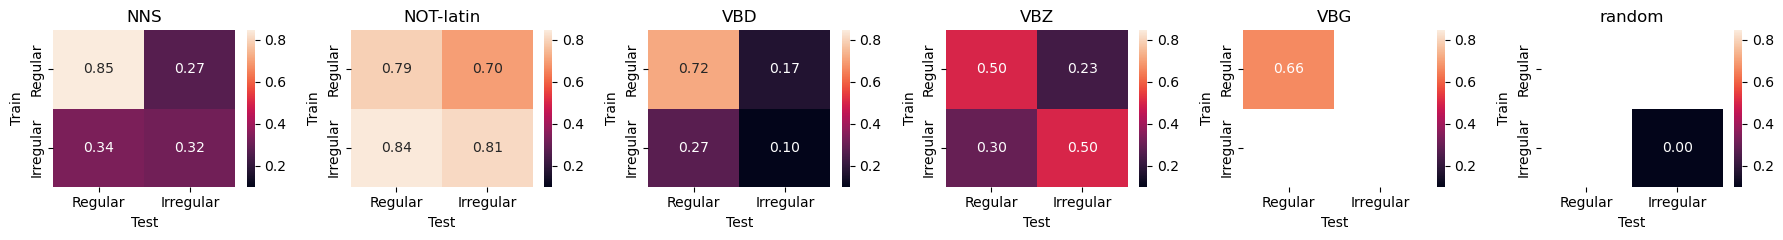

In [13]:
f, ax = plt.subplots(1, len(plot_regular_inflections), figsize=(3 * len(plot_regular_inflections), 2.5),
                     squeeze=True)

regular_df = experiment_results.loc["regular"]
regular_df = pd.concat([regular_df, pd.DataFrame(regular_df.group.tolist()).add_prefix("group")], axis=1)
regular_transfer_df = experiment_results.loc["regular_to_irregular"]
regular_transfer_df["group"] = regular_transfer_df.group.str[0]
irregular_transfer_df = experiment_results.loc["irregular_to_regular"]
irregular_transfer_df["group"] = irregular_transfer_df.group.str[0]
regular_results = {}
for inflection in plot_regular_inflections:
    regular_results[inflection] = np.array([
        [regular_df.query("group0 == @inflection and group1 == True").correct.mean(),
         regular_transfer_df.query("group == @inflection").correct.mean()],
        [irregular_transfer_df.query("group == @inflection").correct.mean(),
         regular_df.query("group0 == @inflection and group1 == False").correct.mean()],
    ])

vmin = min(v.min() for v in regular_results.values())
vmax = max(v.max() for v in regular_results.values())
for ax, inflection in zip(ax, plot_regular_inflections):
    sns.heatmap(regular_results[inflection], annot=True, fmt=".2f", ax=ax,
                vmin=vmin, vmax=vmax, cbar=True,
                xticklabels=["Regular", "Irregular"],
                yticklabels=["Regular", "Irregular"])
    ax.set_title(inflection)
    ax.set_xlabel("Test")
    ax.set_ylabel("Train")

f.tight_layout()

#### Root NN/VB ambiguity

In [14]:
inflection_results_df.groupby(["inflection", "base_ambig_NN_VB"]).size()

inflection  base_ambig_NN_VB
NNS         False               788
            True                387
VBZ         False                61
            True                660
dtype: int64

In [15]:
inflection_results_df.groupby(["inflection", "base_ambig_NN_VB"]).sample(5)

,inflected,base,is_regular,base_idx,inflected_idx,base_ambig_NN_VB
inflection,,,,,,
NNS,weapons,weapon,True,11000,7153,False
NNS,lanes,lane,True,3743,6579,False
NNS,champions,champion,True,9522,11926,False
NNS,frogs,frog,True,8891,16405,False
NNS,signatures,signature,True,11622,10685,False
NNS,races,race,True,496,6812,True
NNS,excuses,excuse,True,3457,3113,True
NNS,bits,bit,True,2477,10027,True
NNS,spots,spot,True,538,492,True


In [31]:
agg_nnvb_results = []

nnvb_expts = experiment_results.index.get_level_values("experiment").unique()
nnvb_expts = nnvb_expts[nnvb_expts.str.contains("unambiguous-")]

for expt in nnvb_expts:
    inflection_from, allomorph_from, inflection_to, allomorph_to = \
        re.findall(r"unambiguous-(\w+)_([\w\s]+)_to_(\w+)_([\w\s]+)", expt)[0]
    expt_df = experiment_results.loc[expt].copy()
    expt_df["inflection_from"] = inflection_from
    expt_df["allomorph_from"] = allomorph_from
    expt_df["inflection_to"] = inflection_to
    expt_df["allomorph_to"] = allomorph_to

    agg_nnvb_results.append(expt_df)

all_nnvb_results = pd.concat(agg_nnvb_results)

In [278]:
nnvbdf = experiment_results.loc["nn_vb_ambiguous"]
nnvbdf = pd.concat([nnvbdf, pd.DataFrame(nnvbdf.group.tolist()).add_prefix("group")], axis=1)
# include only unambiguous bases
nnvbdf = nnvbdf.query("group1 == False")

In [279]:
# merge back in allomorph metadata
allomorphs_to_merge = most_common_allomorphs \
    .set_index(["inflection", "base"]).most_common_allomorph
nnvbdf = pd.merge(nnvbdf, allomorphs_to_merge.rename("allomorph_from"),
                  how="left",
                  left_on=["inflection_from", "base_from"],
                  right_on=["inflection", "base"],
                  validate="m:1")
nnvbdf = pd.merge(nnvbdf, allomorphs_to_merge.rename("allomorph_to"),
                  how="left",
                  left_on=["inflection_to", "base_to"],
                  right_on=["inflection", "base"],
                  validate="m:1")
nnvbdf

,group,from_equiv_label,to_equiv_label,base_from,base_to,inflection_from,inflection_to,predicted_label_idx,predicted_label,predicted_instance_idx,gt_label,gt_label_idx,gt_label_rank,gt_distance,correct,group0,group1,allomorph_from,allomorph_to
0,"(NNS, False)","[caprice, caprices]","[mirror, mirrors]",caprice,mirror,NNS,NNS,6124.0,mirrors,8.0,mirrors,6124.0,0.0,0.839133,True,NNS,False,AH Z,Z
1,"(NNS, False)","[method, methods]","[gun, guns]",method,gun,NNS,NNS,7064.0,guns,11.0,guns,7064.0,0.0,1.089311,True,NNS,False,Z,Z
2,"(NNS, False)","[fleet, fleets]","[variety, varieties]",fleet,variety,NNS,NNS,12417.0,varieties,5.0,varieties,12417.0,0.0,0.770403,True,NNS,False,S,Z
3,"(NNS, False)","[card, cards]","[jewel, jewels]",card,jewel,NNS,NNS,1687.0,jewels,8.0,jewels,1687.0,0.0,1.090018,True,NNS,False,Z,Z
4,"(NNS, False)","[blanket, blankets]","[fur, furs]",blanket,fur,NNS,NNS,3584.0,fir,6.0,furs,2055.0,2.0,1.418233,False,NNS,False,S,Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,"(VBZ, False)","[describe, describes]","[send, sends]",describe,send,VBZ,VBZ,7530.0,sends,1.0,sends,7530.0,0.0,0.868546,True,VBZ,False,Z,Z
1996,"(VBZ, False)","[remember, remembers]","[belong, belongs]",remember,belong,VBZ,VBZ,1616.0,belongs,7.0,belongs,1616.0,0.0,0.714665,True,VBZ,False,Z,Z
1997,"(VBZ, False)","[sit, sits]","[please, pleases]",sit,please,VBZ,VBZ,3087.0,pleases,8.0,pleases,3087.0,0.0,1.362431,True,VBZ,False,S,IH Z
1998,"(VBZ, False)","[serve, serves]","[contain, contains]",serve,contain,VBZ,VBZ,4637.0,contains,3.0,contains,4637.0,0.0,1.146405,True,VBZ,False,Z,Z


In [280]:
nn_to_vb_df = experiment_results.loc["NNS_to_VBZ_strict"]
# merge back in allomorph data
nn_to_vb_df = pd.merge(nn_to_vb_df, allomorphs_to_merge.rename("allomorph_from"),
                       how="left",
                       left_on=["inflection_from", "base_from"],
                       right_on=["inflection", "base"],
                       validate="m:1")
nn_to_vb_df = pd.merge(nn_to_vb_df, allomorphs_to_merge.rename("allomorph_to"),
                          how="left",
                          left_on=["inflection_to", "base_to"],
                          right_on=["inflection", "base"],
                          validate="m:1")
nn_to_vb_df

,group,from_equiv_label,to_equiv_label,base_from,base_to,inflection_from,inflection_to,predicted_label_idx,predicted_label,predicted_instance_idx,gt_label,gt_label_idx,gt_label_rank,gt_distance,correct,allomorph_from,allomorph_to
0,,"[caprice, caprices]","[write, writes]",caprice,write,NNS,VBZ,4472.0,rights,25.0,writes,3067.0,5.0,0.492293,False,AH Z,S
1,,"[method, methods]","[tell, tells]",method,tell,NNS,VBZ,2667.0,tells,12.0,tells,2667.0,0.0,1.140172,True,Z,Z
2,,"[fleet, fleets]","[write, writes]",fleet,write,NNS,VBZ,4472.0,rights,25.0,writes,3067.0,5.0,0.578846,False,S,S
3,,"[card, cards]","[remember, remembers]",card,remember,NNS,VBZ,15307.0,remembers,5.0,remembers,15307.0,0.0,0.663927,True,Z,Z
4,,"[blanket, blankets]","[become, becomes]",blanket,become,NNS,VBZ,5688.0,becomes,23.0,becomes,5688.0,0.0,1.211625,True,S,Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,,"[paper, papers]","[happen, happens]",paper,happen,NNS,VBZ,4389.0,happens,2.0,happens,4389.0,0.0,0.883004,True,Z,Z
996,,"[structure, structures]","[tell, tells]",structure,tell,NNS,VBZ,2667.0,tells,4.0,tells,2667.0,0.0,1.052633,True,Z,Z
997,,"[fowl, fowls]","[write, writes]",fowl,write,NNS,VBZ,4472.0,rights,1.0,writes,3067.0,27.0,0.829864,False,Z,S
998,,"[hardship, hardships]","[eat, eats]",hardship,eat,NNS,VBZ,11348.0,eats,1.0,eats,11348.0,0.0,1.149894,True,S,S


In [281]:
vb_to_nn_df = experiment_results.loc["VBZ_to_NNS_strict"]
# merge back in allomorph data
vb_to_nn_df = pd.merge(vb_to_nn_df, allomorphs_to_merge.rename("allomorph_from"),
                       how="left",
                       left_on=["inflection_from", "base_from"],
                       right_on=["inflection", "base"],
                       validate="m:1")
vb_to_nn_df = pd.merge(vb_to_nn_df, allomorphs_to_merge.rename("allomorph_to"),
                          how="left",
                          left_on=["inflection_to", "base_to"],
                          right_on=["inflection", "base"],
                          validate="m:1")
vb_to_nn_df

,group,from_equiv_label,to_equiv_label,base_from,base_to,inflection_from,inflection_to,predicted_label_idx,predicted_label,predicted_instance_idx,gt_label,gt_label_idx,gt_label_rank,gt_distance,correct,allomorph_from,allomorph_to
0,,"[possess, possesses]","[direction, directions]",possess,direction,VBZ,NNS,885.0,directions,1.0,directions,885.0,0.0,0.882703,True,IH Z,Z
1,,"[sit, sits]","[element, elements]",sit,element,VBZ,NNS,4893.0,elements,12.0,elements,4893.0,0.0,0.901178,True,S,S
2,,"[insist, insists]","[prisoner, prisoners]",insist,prisoner,VBZ,NNS,9153.0,prisoners,16.0,prisoners,9153.0,0.0,1.326899,True,S,Z
3,,"[describe, describes]","[bond, bonds]",describe,bond,VBZ,NNS,13086.0,bonds,11.0,bonds,13086.0,0.0,0.626879,True,Z,Z
4,,"[read, reads]","[meter, meters]",read,meter,VBZ,NNS,245.0,meters,19.0,meters,245.0,0.0,1.075882,True,Z,Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,,"[write, writes]","[kind, kinds]",write,kind,VBZ,NNS,2934.0,kinds,1.0,kinds,2934.0,0.0,1.096665,True,S,Z
996,,"[tend, tends]","[village, villages]",tend,village,VBZ,NNS,8671.0,villages,0.0,villages,8671.0,0.0,1.277797,True,Z,IH Z
997,,"[do, does]","[mink, minks]",do,mink,VBZ,NNS,7195.0,menace,5.0,minks,26433.0,491.0,0.923564,False,AH Z,S
998,,"[seem, seems]","[region, regions]",seem,region,VBZ,NNS,5326.0,regions,15.0,regions,5326.0,0.0,0.860399,True,Z,Z


In [232]:
all_nnvb_results = pd.concat([nnvbdf, nn_to_vb_df, vb_to_nn_df])

In [233]:
nnvb_results_summary = all_nnvb_results.groupby(["inflection_from", "inflection_to",
                                                 "allomorph_from", "allomorph_to"]) \
    .correct.agg(["count", "mean"]) \
    .query("count >= 0") \
    .reset_index()
# DEV retain just S, Z
nnvb_results_summary = nnvb_results_summary.query("allomorph_from in ('S', 'Z') and allomorph_to in ('S', 'Z')")

nnvb_results_summary["source_label"] = nnvb_results_summary.inflection_from + " " + nnvb_results_summary.allomorph_from
nnvb_results_summary["target_label"] = nnvb_results_summary.inflection_to + " " + nnvb_results_summary.allomorph_to

nnvb_results_summary["transfer_label"] = nnvb_results_summary.inflection_from + " -> " + nnvb_results_summary.inflection_to
nnvb_results_summary["phon_label"] = nnvb_results_summary.allomorph_from + " " + nnvb_results_summary.allomorph_to

# only retain cases where we have data in both transfer directions from source <-> target within inflection
nnvb_results_summary["complement_exists"] = nnvb_results_summary.apply(lambda row: len(nnvb_results_summary.query("source_label == @row.target_label and target_label == @row.source_label")), axis=1)
nnvb_results_summary = nnvb_results_summary.query("complement_exists > 0").drop(columns=["complement_exists"])

nnvb_results_summary

,inflection_from,inflection_to,allomorph_from,allomorph_to,count,mean,source_label,target_label,transfer_label,phon_label
20,NNS,NNS,S,S,35,0.914286,NNS S,NNS S,NNS -> NNS,S S
21,NNS,NNS,S,Z,134,0.880597,NNS S,NNS Z,NNS -> NNS,S Z
33,NNS,NNS,Z,S,163,0.766871,NNS Z,NNS S,NNS -> NNS,Z S
36,NNS,NNS,Z,Z,451,0.820399,NNS Z,NNS Z,NNS -> NNS,Z Z
60,NNS,VBZ,S,S,44,0.613636,NNS S,VBZ S,NNS -> VBZ,S S
61,NNS,VBZ,S,Z,123,0.560976,NNS S,VBZ Z,NNS -> VBZ,S Z
69,NNS,VBZ,Z,S,182,0.626374,NNS Z,VBZ S,NNS -> VBZ,Z S
70,NNS,VBZ,Z,Z,461,0.613883,NNS Z,VBZ Z,NNS -> VBZ,Z Z
94,VBZ,NNS,S,S,51,0.823529,VBZ S,NNS S,VBZ -> NNS,S S
96,VBZ,NNS,S,Z,164,0.798780,VBZ S,NNS Z,VBZ -> NNS,S Z


<Axes: xlabel='target_label', ylabel='source_label'>

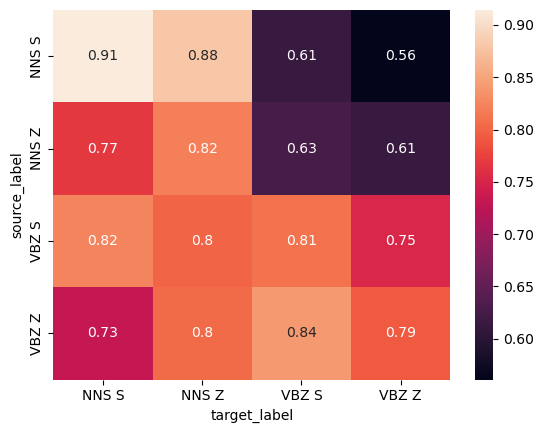

In [234]:
sns.heatmap(nnvb_results_summary.set_index(["source_label", "target_label"]).sort_index()["mean"].unstack("target_label"), annot=True)

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


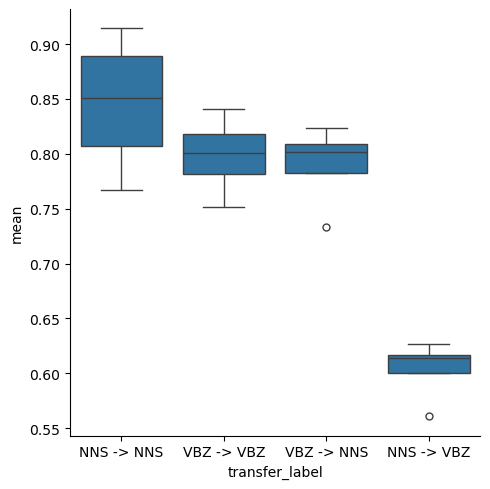

In [235]:
# sns.catplot(data=nnvb_results_summary, x="transfer_label", y="mean", hue="phon_label", kind="swarm", aspect=2)
order = nnvb_results_summary.groupby("transfer_label")["mean"].mean().sort_values(ascending=False).index
sns.catplot(data=nnvb_results_summary, x="transfer_label", y="mean", kind="box", order=order)

Text(0.5, 1.0, 'Accuracy')

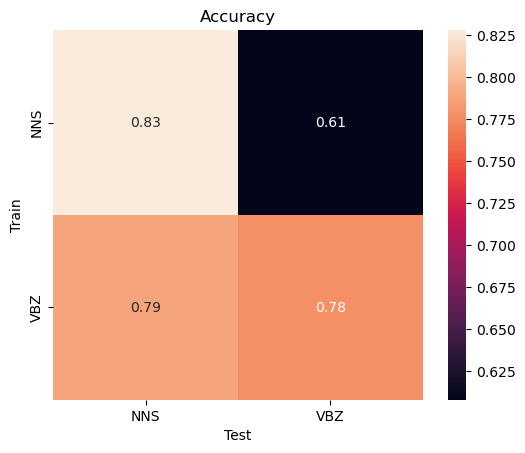

In [35]:
nns_vbz_strict_generalization = np.array([
    [nnvbdf.query("group0 == 'NNS' and group1 == False").correct.mean(),
     experiment_results.loc["NNS_to_VBZ_strict"].correct.mean()],
    [experiment_results.loc["VBZ_to_NNS_strict"].correct.mean(),
     nnvbdf.query("group0 == 'VBZ' and group1 == False").correct.mean()],
])
ax = sns.heatmap(nns_vbz_strict_generalization, annot=True, square=True, xticklabels=["NNS", "VBZ"], yticklabels=["NNS", "VBZ"])
ax.set_xlabel("Test")
ax.set_ylabel("Train")
ax.set_title("Accuracy")

Text(0.5, 1.0, 'Median rank of GT')

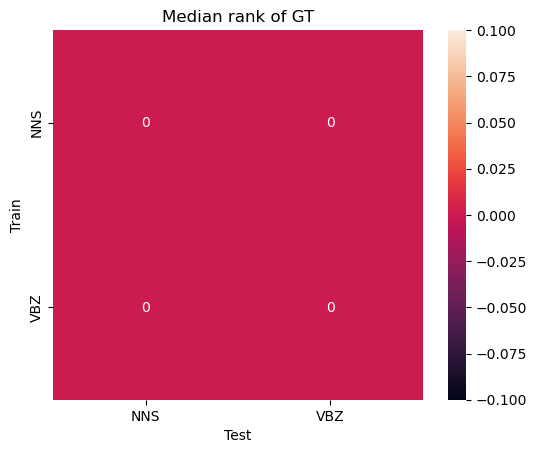

In [36]:
nns_vbz_strict_generalization = np.array([
    [nnvbdf.query("group0 == 'NNS' and group1 == False").gt_label_rank.median(),
     experiment_results.loc["NNS_to_VBZ_strict"].gt_label_rank.median()],
    [experiment_results.loc["VBZ_to_NNS_strict"].gt_label_rank.median(),
     nnvbdf.query("group0 == 'VBZ' and group1 == False").gt_label_rank.median()],
])
ax = sns.heatmap(nns_vbz_strict_generalization, annot=True, square=True, xticklabels=["NNS", "VBZ"], yticklabels=["NNS", "VBZ"])
ax.set_xlabel("Test")
ax.set_ylabel("Train")
ax.set_title("Median rank of GT")

Text(0.5, 1.0, 'Mean rank of GT')

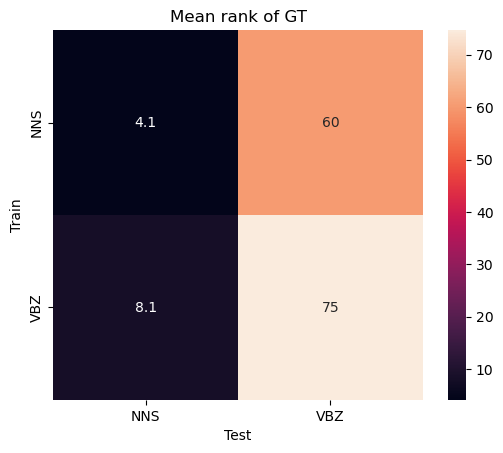

In [37]:
nns_vbz_strict_generalization = np.array([
    [nnvbdf.query("group0 == 'NNS' and group1 == False").gt_label_rank.mean(),
     experiment_results.loc["NNS_to_VBZ_strict"].gt_label_rank.mean()],
    [experiment_results.loc["VBZ_to_NNS_strict"].gt_label_rank.mean(),
     nnvbdf.query("group0 == 'VBZ' and group1 == False").gt_label_rank.mean()],
])
ax = sns.heatmap(nns_vbz_strict_generalization, annot=True, square=True, xticklabels=["NNS", "VBZ"], yticklabels=["NNS", "VBZ"])
ax.set_xlabel("Test")
ax.set_ylabel("Train")
ax.set_title("Mean rank of GT")

Text(0.5, 1.0, 'Median distance to GT')

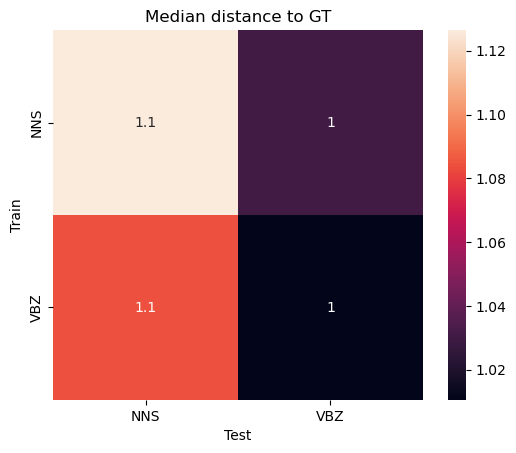

In [38]:
nns_vbz_strict_generalization = np.array([
    [nnvbdf.query("group0 == 'NNS' and group1 == False").gt_distance.median(),
     experiment_results.loc["NNS_to_VBZ_strict"].gt_distance.median()],
    [experiment_results.loc["VBZ_to_NNS_strict"].gt_distance.median(),
     nnvbdf.query("group0 == 'VBZ' and group1 == False").gt_distance.median()],
])
ax = sns.heatmap(nns_vbz_strict_generalization, annot=True, square=True, xticklabels=["NNS", "VBZ"], yticklabels=["NNS", "VBZ"])
ax.set_xlabel("Test")
ax.set_ylabel("Train")
ax.set_title("Median distance to GT")

##### False friends

In [236]:
nns_false_friends = experiment_results.loc["false_friends"]
nns_false_friends = nns_false_friends[nns_false_friends.group.str[0].str.startswith("NNS")]
nns_false_friends["allomorph_from"] = nns_false_friends.from_equiv_label.str[-1]
nns_false_friends["allomorph_to"] = nns_false_friends.to_equiv_label.str[-1]
nns_false_friends

,group,from_equiv_label,to_equiv_label,base_from,base_to,inflection_from,inflection_to,predicted_label_idx,predicted_label,predicted_instance_idx,gt_label,gt_label_idx,gt_label_rank,gt_distance,correct,allomorph_from,allomorph_to
0,"(NNS-FF-S,)","[scare, scarce, S]","[philip, phillips, S]",scare,philip,NNS-FF-S,NNS-FF-S,17071.0,philip's,8.0,phillips,29466.0,1.0,1.158379,False,S,S
1,"(NNS-FF-S,)","[p, peace, S]","[jew, juice, S]",p,jew,NNS-FF-S,NNS-FF-S,14807.0,tutor,4.0,juice,9374.0,2.0,1.090790,False,S,S
2,"(NNS-FF-S,)","[flee, fleece, S]","[fall, false, S]",flee,fall,NNS-FF-S,NNS-FF-S,4580.0,flocks,12.0,false,4725.0,3.0,1.300166,False,S,S
3,"(NNS-FF-S,)","[then, thence, S]","[wreck, rex, S]",then,wreck,NNS-FF-S,NNS-FF-S,29928.0,rafts,1.0,rex,26926.0,1.0,1.019610,False,S,S
4,"(NNS-FF-S,)","[den, dense, S]","[a, us, S]",den,a,NNS-FF-S,NNS-FF-S,2547.0,herself,38.0,us,903.0,11119.0,0.827336,False,S,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,"(NNS-FF-Z,)","[wandering, wanderings, Z]","[fro, froze, Z]",wandering,fro,NNS-FF-Z,NNS-FF-Z,1098.0,forest,20.0,froze,15680.0,7.0,1.309546,False,Z,Z
1996,"(NNS-FF-Z,)","[chiu, choose, Z]","[ho, hose, Z]",chiu,ho,NNS-FF-Z,NNS-FF-Z,12572.0,recall,2.0,hose,2736.0,8434.0,0.971555,False,Z,Z
1997,"(NNS-FF-Z,)","[unaware, unawares, Z]","[backward, backwards, Z]",unaware,backward,NNS-FF-Z,NNS-FF-Z,5943.0,backwards,8.0,backwards,5943.0,0.0,0.984684,True,Z,Z
1998,"(NNS-FF-Z,)","[chiu, choose, Z]","[toward, towards, Z]",chiu,toward,NNS-FF-Z,NNS-FF-Z,1836.0,towards,13.0,towards,1836.0,0.0,1.195129,True,Z,Z


Index(['NNS-FF-IH Z-to-NNS_Z', 'NNS_Z-to-NNS-FF-IH Z', 'NNS-FF-IH Z-to-NNS_S',
       'NNS_S-to-NNS-FF-IH Z', 'NNS-FF-IH Z-to-NNS_IH Z',
       'NNS_IH Z-to-NNS-FF-IH Z', 'NNS-FF-S-to-NNS_Z', 'NNS_Z-to-NNS-FF-S',
       'NNS-FF-S-to-NNS_S', 'NNS_S-to-NNS-FF-S', 'NNS-FF-S-to-NNS_IH Z',
       'NNS_IH Z-to-NNS-FF-S', 'VBZ-FF-IH Z-to-VBZ_Z', 'VBZ_Z-to-VBZ-FF-IH Z',
       'VBZ-FF-IH Z-to-VBZ_S', 'VBZ_S-to-VBZ-FF-IH Z',
       'VBZ-FF-IH Z-to-VBZ_IH Z', 'VBZ_IH Z-to-VBZ-FF-IH Z',
       'VBZ-FF-S-to-VBZ_Z', 'VBZ_Z-to-VBZ-FF-S', 'VBZ-FF-S-to-VBZ_S',
       'VBZ_S-to-VBZ-FF-S', 'VBZ-FF-S-to-VBZ_IH Z', 'VBZ_IH Z-to-VBZ-FF-S',
       'VBZ-FF-Z-to-VBZ_Z', 'VBZ_Z-to-VBZ-FF-Z', 'VBZ-FF-Z-to-VBZ_S',
       'VBZ_S-to-VBZ-FF-Z', 'VBZ-FF-Z-to-VBZ_IH Z', 'VBZ_IH Z-to-VBZ-FF-Z'],
      dtype='object', name='experiment')

In [334]:
nns_false_friends_transfer = []
false_friends_transfer_experiments = experiment_results.index.get_level_values("experiment").unique()
false_friends_transfer_experiments = false_friends_transfer_experiments[false_friends_transfer_experiments.str.contains("-FF-")]
false_friends_transfer_experiments = false_friends_transfer_experiments[false_friends_transfer_experiments.str.contains("NNS")]

for expt_name in false_friends_transfer_experiments:
    results_i = experiment_results.loc[expt_name]

    false_friends_from = results_i["inflection_from"].str.contains("-FF-").iloc[0]
    
    orig_length = len(results_i)
    if false_friends_from:
        # false friend is on the "from" end
        false_friends_merge_key = ("inflection_to", "base_from", "gt_label")
        # real is on the "to" end
        real_merge_key = ("inflection_to", "base_to")
    else:
        false_friends_merge_key = ("inflection_from", "base_to", "gt_label")
        real_merge_key = ("inflection_from", "base_from")
        
    results_i = pd.merge(
        results_i,
        allomorphs_to_merge.rename("allomorph_to" if false_friends_from else "allomorph_from"),
        how="left",
        left_on=real_merge_key,
        right_on=["inflection", "base"],
        validate="m:1")
    results_i = pd.merge(
        results_i,
        false_friends_df.drop(columns=["base_form", "inflected_form"]).reset_index()
        .drop_duplicates()
        .rename(columns={"post_divergence": "allomorph_to", "inflection": false_friends_merge_key[0],
                         "base": false_friends_merge_key[1], "inflected": "gt_label"}),
        how="left", on=false_friends_merge_key,
        validate="m:1")
    
    assert len(results_i) == orig_length

    nns_false_friends_transfer.append(results_i)

In [335]:
all_nns_false_friend_results = pd.concat([nns_false_friends] + nns_false_friends_transfer)

In [336]:
nns_false_friend_summary = all_nns_false_friend_results.groupby(["inflection_from", "inflection_to",
                                                                    "allomorph_from", "allomorph_to"]) \
        .correct.agg(["count", "mean"]) \
        .query("count >= 0") \
        .reset_index()
nns_false_friend_summary

,inflection_from,inflection_to,allomorph_from,allomorph_to,count,mean
0,NNS,NNS-FF-IH Z,IH Z,IH Z,5,1.000
1,NNS,NNS-FF-IH Z,S,IH Z,5,0.400
2,NNS,NNS-FF-IH Z,Z,IH Z,5,0.600
3,NNS,NNS-FF-S,IH Z,S,5,0.000
4,NNS,NNS-FF-S,S,S,5,0.200
5,NNS,NNS-FF-S,Z,S,5,0.000
6,NNS-FF-S,NNS-FF-S,S,S,1000,0.106
7,NNS-FF-Z,NNS-FF-Z,Z,Z,1000,0.394


##### Frequency analysis

In [330]:
word_freq_df = pd.read_csv("data/WorldLex_Eng_US.Freq.2.txt", sep="\t", index_col="Word")
# compute weighted average frequency across domains
word_freq_df["BlogFreq_rel"] = word_freq_df.BlogFreq / word_freq_df.BlogFreq.sum()
word_freq_df["TwitterFreq_rel"] = word_freq_df.TwitterFreq / word_freq_df.TwitterFreq.sum()
word_freq_df["NewsFreq_rel"] = word_freq_df.NewsFreq / word_freq_df.NewsFreq.sum()
word_freq_df["Freq"] = word_freq_df[["BlogFreq", "TwitterFreq", "NewsFreq"]].mean(axis=1) \
    * word_freq_df[["BlogFreq", "TwitterFreq", "NewsFreq"]].sum().mean()
word_freq_df["LogFreq"] = np.log10(word_freq_df.Freq)

In [334]:
all_nnvb_results = pd.merge(all_nnvb_results, word_freq_df.LogFreq.rename("from_freq"),
                              left_on="base_from", right_index=True)
all_nnvb_results = pd.merge(all_nnvb_results, word_freq_df.LogFreq.rename("to_freq"),
                              left_on="base_to", right_index=True)

In [335]:
all_nnvb_results["to_freq_bin"] = pd.cut(all_nnvb_results.to_freq, bins=5)
all_nnvb_results["from_freq_bin"] = pd.cut(all_nnvb_results.from_freq, bins=5)

In [336]:
all_nnvb_results.groupby(["inflection_from", "inflection_to", "from_freq_bin", "base_from"]).correct.mean().dropna().reset_index().groupby(["inflection_from", "inflection_to"]).size()

/tmp/ipykernel_3904846/3689112148.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_nnvb_results.groupby(["inflection_from", "inflection_to", "from_freq_bin", "base_from"]).correct.mean().dropna().reset_index().groupby(["inflection_from", "inflection_to"]).size()


inflection_from  inflection_to
NNS              NNS              548
                 VBZ              548
VBZ              NNS               59
                 VBZ               59
dtype: int64

/tmp/ipykernel_3904846/4180899553.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.catplot(data=all_nnvb_results.groupby(["inflection_from", "inflection_to", "from_freq_bin", "base_from"]).correct.mean().dropna().reset_index(),
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/

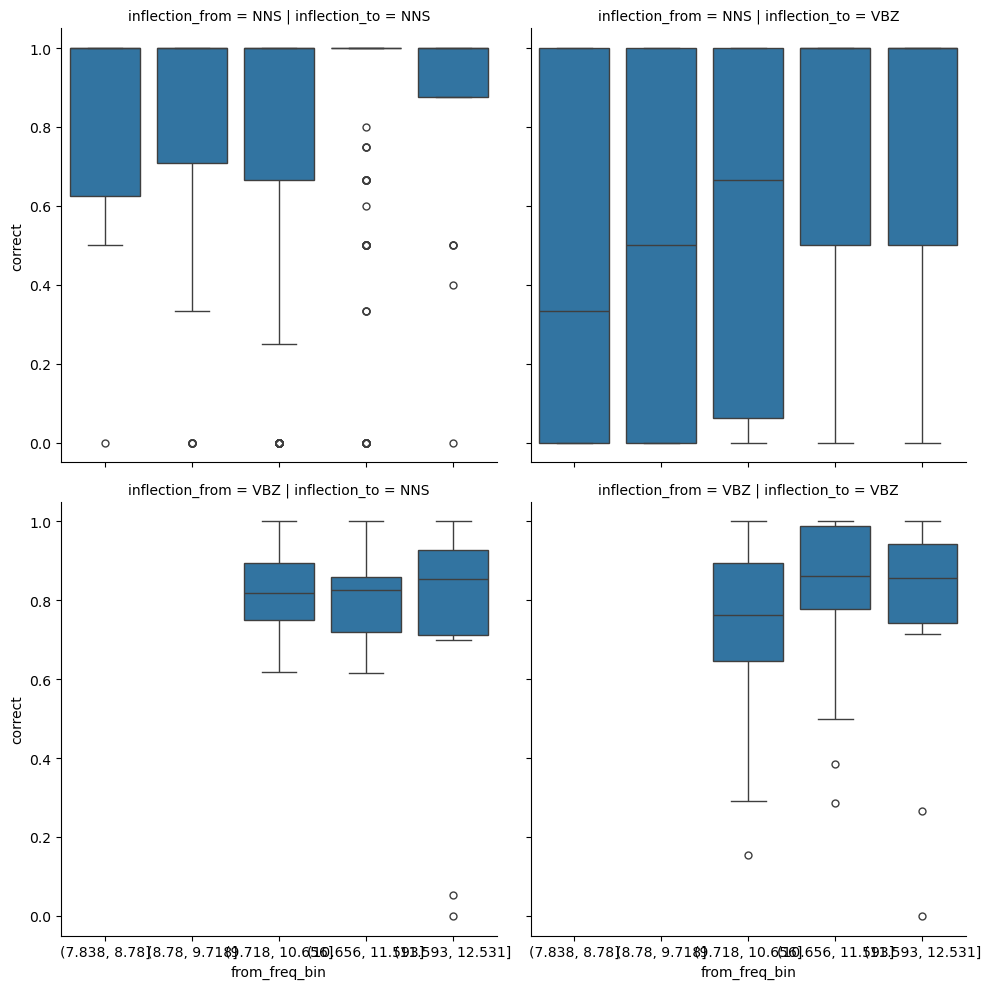

In [339]:
sns.catplot(data=all_nnvb_results.groupby(["inflection_from", "inflection_to", "from_freq_bin", "base_from"]).correct.mean().dropna().reset_index(),
            x="from_freq_bin", y="correct", kind="box", row="inflection_from", col="inflection_to")

/tmp/ipykernel_3904846/3535029011.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.catplot(data=all_nnvb_results.groupby(["inflection_from", "inflection_to", "to_freq_bin", "base_from"]).correct.mean().dropna().reset_index(),


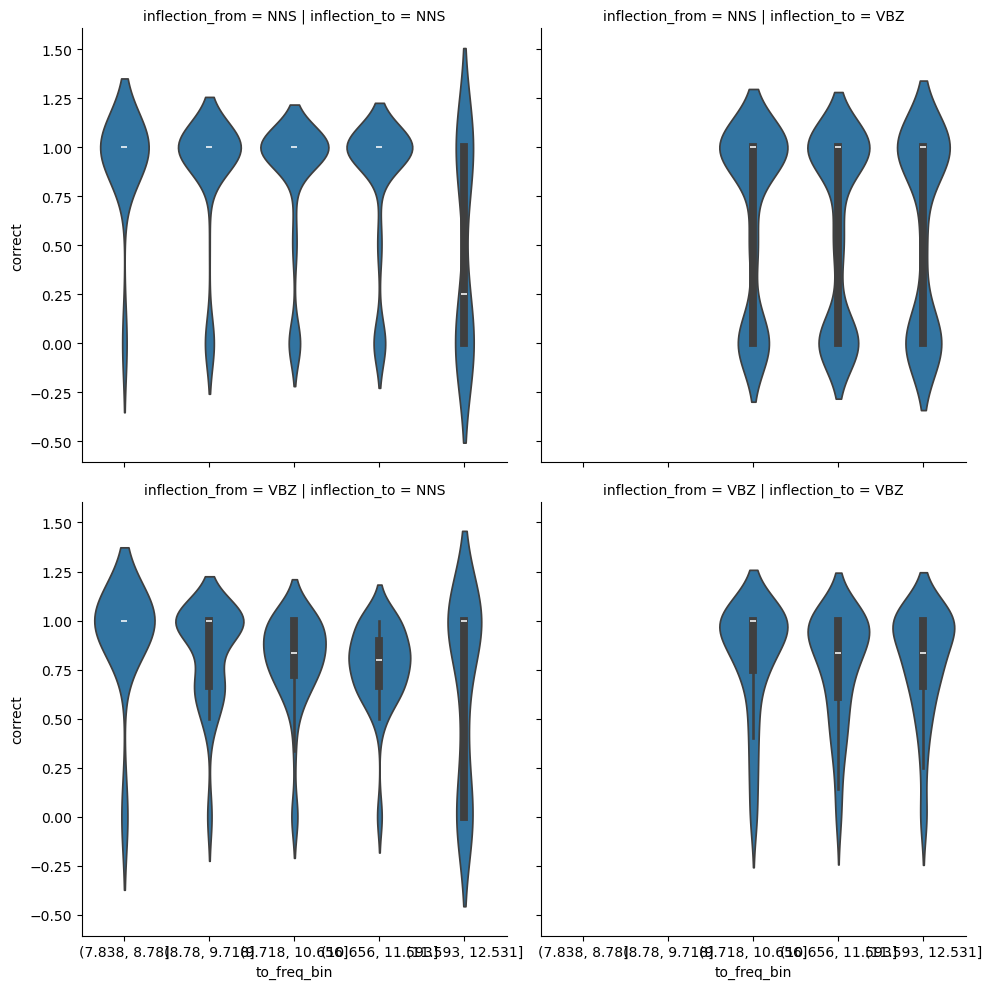

In [338]:
sns.catplot(data=all_nnvb_results.groupby(["inflection_from", "inflection_to", "to_freq_bin", "base_from"]).correct.mean().dropna().reset_index(),
            x="to_freq_bin", y="correct", kind="violin", row="inflection_from", col="inflection_to")

### Representational analysis

In [39]:
rep_spec_df = experiment_results.loc["nn_vb_ambiguous"]
rep_spec_df["inflection"] = rep_spec_df.group.str[0]
rep_spec_df["ambiguous"] = rep_spec_df.group.str[1]
rep_spec_df = rep_spec_df[~rep_spec_df.ambiguous]
rep_spec_df

/tmp/ipykernel_524046/287926604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rep_spec_df["inflection"] = rep_spec_df.group.str[0]
/tmp/ipykernel_524046/287926604.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rep_spec_df["ambiguous"] = rep_spec_df.group.str[1]


,group,from_equiv_label,to_equiv_label,base_from,base_to,inflection_from,inflection_to,predicted_label_idx,predicted_label,predicted_instance_idx,gt_label,gt_label_idx,gt_label_rank,gt_distance,correct,inflection,ambiguous
0,"(NNS, False)","[caprice, caprices]","[mirror, mirrors]",caprice,mirror,NNS,NNS,6124.0,mirrors,8.0,mirrors,6124.0,0.0,0.839133,True,NNS,False
1,"(NNS, False)","[method, methods]","[gun, guns]",method,gun,NNS,NNS,7064.0,guns,11.0,guns,7064.0,0.0,1.089311,True,NNS,False
2,"(NNS, False)","[fleet, fleets]","[variety, varieties]",fleet,variety,NNS,NNS,12417.0,varieties,5.0,varieties,12417.0,0.0,0.770403,True,NNS,False
3,"(NNS, False)","[card, cards]","[jewel, jewels]",card,jewel,NNS,NNS,1687.0,jewels,8.0,jewels,1687.0,0.0,1.090018,True,NNS,False
4,"(NNS, False)","[blanket, blankets]","[fur, furs]",blanket,fur,NNS,NNS,3584.0,fir,6.0,furs,2055.0,2.0,1.418233,False,NNS,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,"(VBZ, False)","[describe, describes]","[send, sends]",describe,send,VBZ,VBZ,7530.0,sends,1.0,sends,7530.0,0.0,0.868546,True,VBZ,False
2996,"(VBZ, False)","[remember, remembers]","[belong, belongs]",remember,belong,VBZ,VBZ,1616.0,belongs,7.0,belongs,1616.0,0.0,0.714665,True,VBZ,False
2997,"(VBZ, False)","[sit, sits]","[please, pleases]",sit,please,VBZ,VBZ,3087.0,pleases,8.0,pleases,3087.0,0.0,1.362431,True,VBZ,False
2998,"(VBZ, False)","[serve, serves]","[contain, contains]",serve,contain,VBZ,VBZ,4637.0,contains,3.0,contains,4637.0,0.0,1.146405,True,VBZ,False


In [40]:
def get_inflection_vectors(results_df, correct_only=True, max_num_vector_samples=250):
    ret = {}
    if correct_only:
        results_df = results_df[results_df.correct]

    for inflection, group in results_df.groupby("inflection"):
        ret[inflection] = {}
        for base_word in group.base_from.unique():
            # HACK look up inflected form which we didn't save
            inflected_word = inflection_results_df.loc[inflection].query("base == @base_word").inflected.iloc[0]

            base_flat_idxs = np.where(agg_src[:, 0] == state_space_spec.labels.index(base_word))[0]
            inflected_flat_idxs = np.where(agg_src[:, 0] == state_space_spec.labels.index(inflected_word))[0]

            if len(base_flat_idxs) > max_num_vector_samples:
                base_flat_idxs = np.random.choice(base_flat_idxs, size=max_num_vector_samples, replace=False)
            elif len(base_flat_idxs) < max_num_vector_samples:
                base_flat_idxs = np.random.choice(base_flat_idxs, size=max_num_vector_samples, replace=True)
            if len(inflected_flat_idxs) > max_num_vector_samples:
                inflected_flat_idxs = np.random.choice(inflected_flat_idxs, size=max_num_vector_samples, replace=False)
            elif len(inflected_flat_idxs) < max_num_vector_samples:
                inflected_flat_idxs = np.random.choice(inflected_flat_idxs, size=max_num_vector_samples, replace=True)

            difference_vectors = (agg[inflected_flat_idxs] - agg[base_flat_idxs]).mean(0)
            ret[inflection][base_word] = difference_vectors

    return ret

In [41]:
infl_vectors = get_inflection_vectors(rep_spec_df)

NameError: name 'agg_src' is not defined

In [343]:
analyze_infl_types = sorted(infl_vectors.keys())
infl_distances = np.zeros((len(analyze_infl_types), len(analyze_infl_types)))
infl_distances_all = []
for i, inflection_i in enumerate(analyze_infl_types):
    for j, inflection_j in enumerate(analyze_infl_types):
        distances = 1 - fastdist.cosine_matrix_to_matrix(
            np.stack([v for v in infl_vectors[inflection_i].values()]),
            np.stack([v for v in infl_vectors[inflection_j].values()])
        )
        infl_distances[i, j] = distances.mean()
        infl_distances_all.extend((inflection_i, inflection_j, d) for d in distances.flatten())

Text(0.5694444444444446, 0.5, 'Cosine distance')

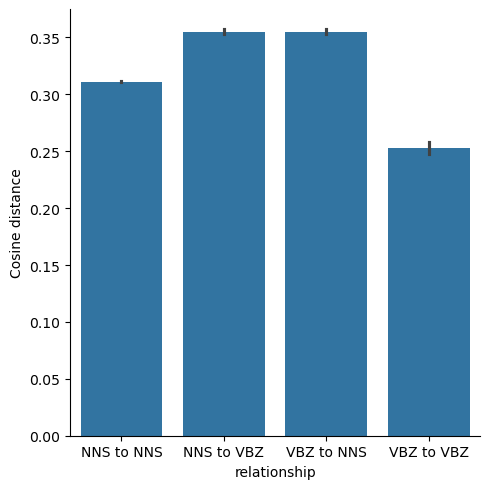

In [344]:
infl_distances_all = pd.DataFrame(infl_distances_all, columns=["inflection_i", "inflection_j", "distance"])
infl_distances_all["relationship"] = infl_distances_all.inflection_i + " to " + infl_distances_all.inflection_j
g = sns.catplot(data=infl_distances_all, x="relationship", y="distance", kind="bar")
g.axes.flat[0].set_ylabel("Cosine distance")

In [345]:
from scipy.stats import ttest_ind

In [346]:
ttest_ind(infl_distances_all.query("relationship == 'NNS to NNS'").distance,
          infl_distances_all.query("relationship == 'VBZ to VBZ'").distance)

TtestResult(statistic=22.562394036737974, pvalue=1.3167190468875617e-112, df=249378.0)

<Axes: >

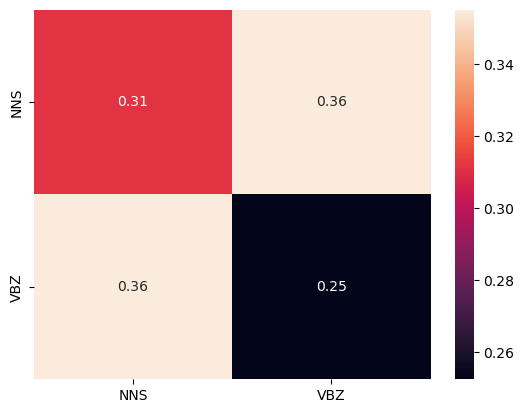

In [347]:
sns.heatmap(pd.DataFrame(infl_distances, index=analyze_infl_types, columns=analyze_infl_types),
            annot=True)

#### Lil PCA thing

In [348]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(agg)
agg_pca = pca.transform(agg)

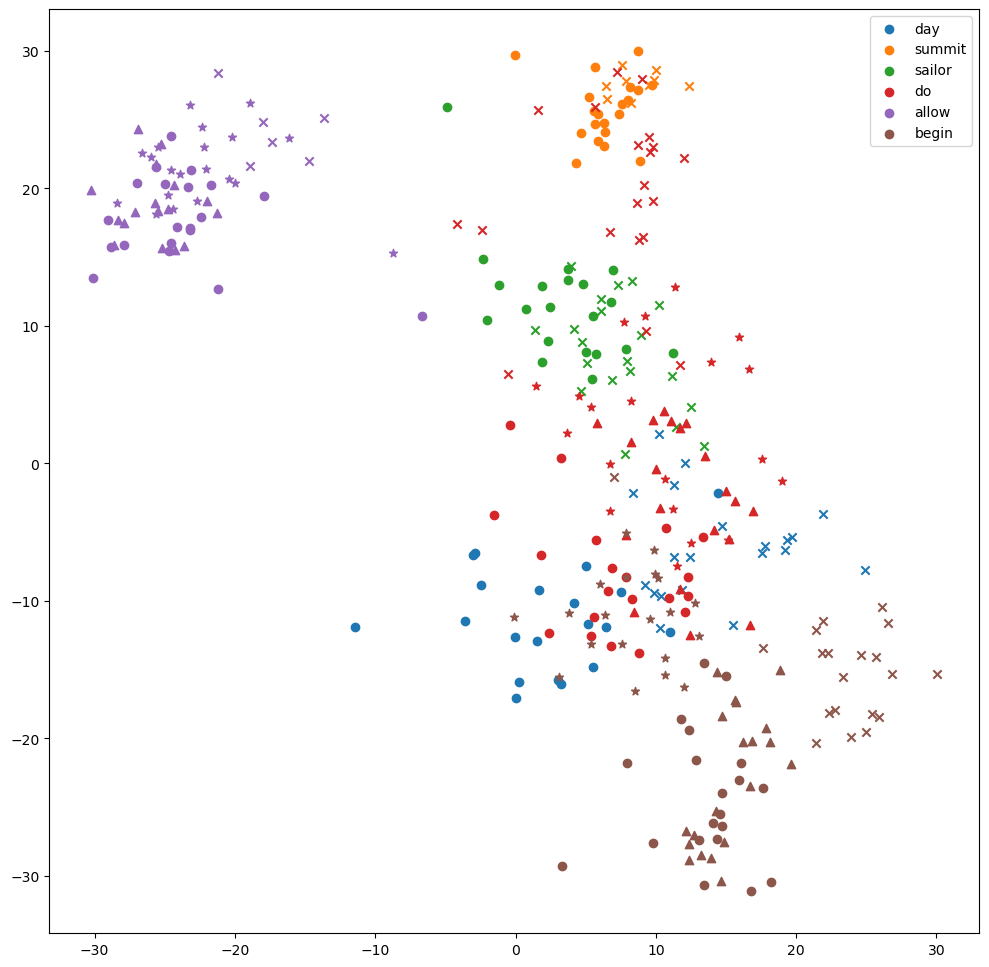

In [349]:
# f, ax = plt.subplots(figsize=(12, 12))
# plot_words = rep_spec_df.groupby("inflection").sample(3)
# cmap = sns.color_palette("tab10", len(plot_words))

# max_plot_points = 20

# for i, (_, row) in enumerate(plot_words.iterrows()):
#     base_flat_idxs = np.where(agg_src[:, 0] == state_space_spec.labels.index(row.base_from))[0]
#     base_reps = agg_pca[base_flat_idxs]
#     if len(base_reps) > max_plot_points:
#         base_reps = base_reps[np.random.choice(len(base_reps), size=max_plot_points, replace=False)]
#     ax.scatter(*base_reps.T, color=cmap[i], label=row.base_from)

#     if row.inflection == "NNS":
#         # get target inflected form
#         nns_form = inflection_results_df.loc["NNS"].query("base == @row.base_from").inflected.iloc[0]
#         inflected_flat_idxs = np.where(agg_src[:, 0] == state_space_spec.labels.index(nns_form))[0]
#         inflected_reps = agg_pca[inflected_flat_idxs]
#         if len(inflected_reps) > max_plot_points:
#             inflected_reps = inflected_reps[np.random.choice(len(inflected_reps), size=max_plot_points, replace=False)]
        
#         ax.scatter(*inflected_reps.T, color=cmap[i], marker="x")
#     elif row.inflection == "VBZ":
#         # get VBZ inflected form
#         vbz_form = inflection_results_df.loc["VBZ"].query("base == @row.base_from").inflected.iloc[0]
#         inflected_flat_idxs = np.where(agg_src[:, 0] == state_space_spec.labels.index(vbz_form))[0]
#         inflected_reps = agg_pca[inflected_flat_idxs]
#         if len(inflected_reps) > max_plot_points:
#             inflected_reps = inflected_reps[np.random.choice(len(inflected_reps), size=max_plot_points, replace=False)]
#         ax.scatter(*inflected_reps.T, color=cmap[i], marker="x")

#         # get VBD inflected form
#         vbd_form = inflection_results_df.loc["VBD"].query("base == @row.base_from").inflected.iloc[0]
#         inflected_flat_idxs = np.where(agg_src[:, 0] == state_space_spec.labels.index(vbd_form))[0]
#         inflected_reps = agg_pca[inflected_flat_idxs]
#         if len(inflected_reps) > max_plot_points:
#             inflected_reps = inflected_reps[np.random.choice(len(inflected_reps), size=max_plot_points, replace=False)]
#         ax.scatter(*inflected_reps.T, color=cmap[i], marker="*")

#         # get VBG inflected form
#         vbg_form = inflection_results_df.loc["VBG"].query("base == @row.base_from").inflected.iloc[0]
#         inflected_flat_idxs = np.where(agg_src[:, 0] == state_space_spec.labels.index(vbg_form))[0]
#         inflected_reps = agg_pca[inflected_flat_idxs]
#         if len(inflected_reps) > max_plot_points:
#             inflected_reps = inflected_reps[np.random.choice(len(inflected_reps), size=max_plot_points, replace=False)]
#         ax.scatter(*inflected_reps.T, color=cmap[i], marker="^")

# plt.legend()

/tmp/ipykernel_3904846/816466026.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_words = rep_spec_df.query("correct").groupby("inflection").apply(draw)


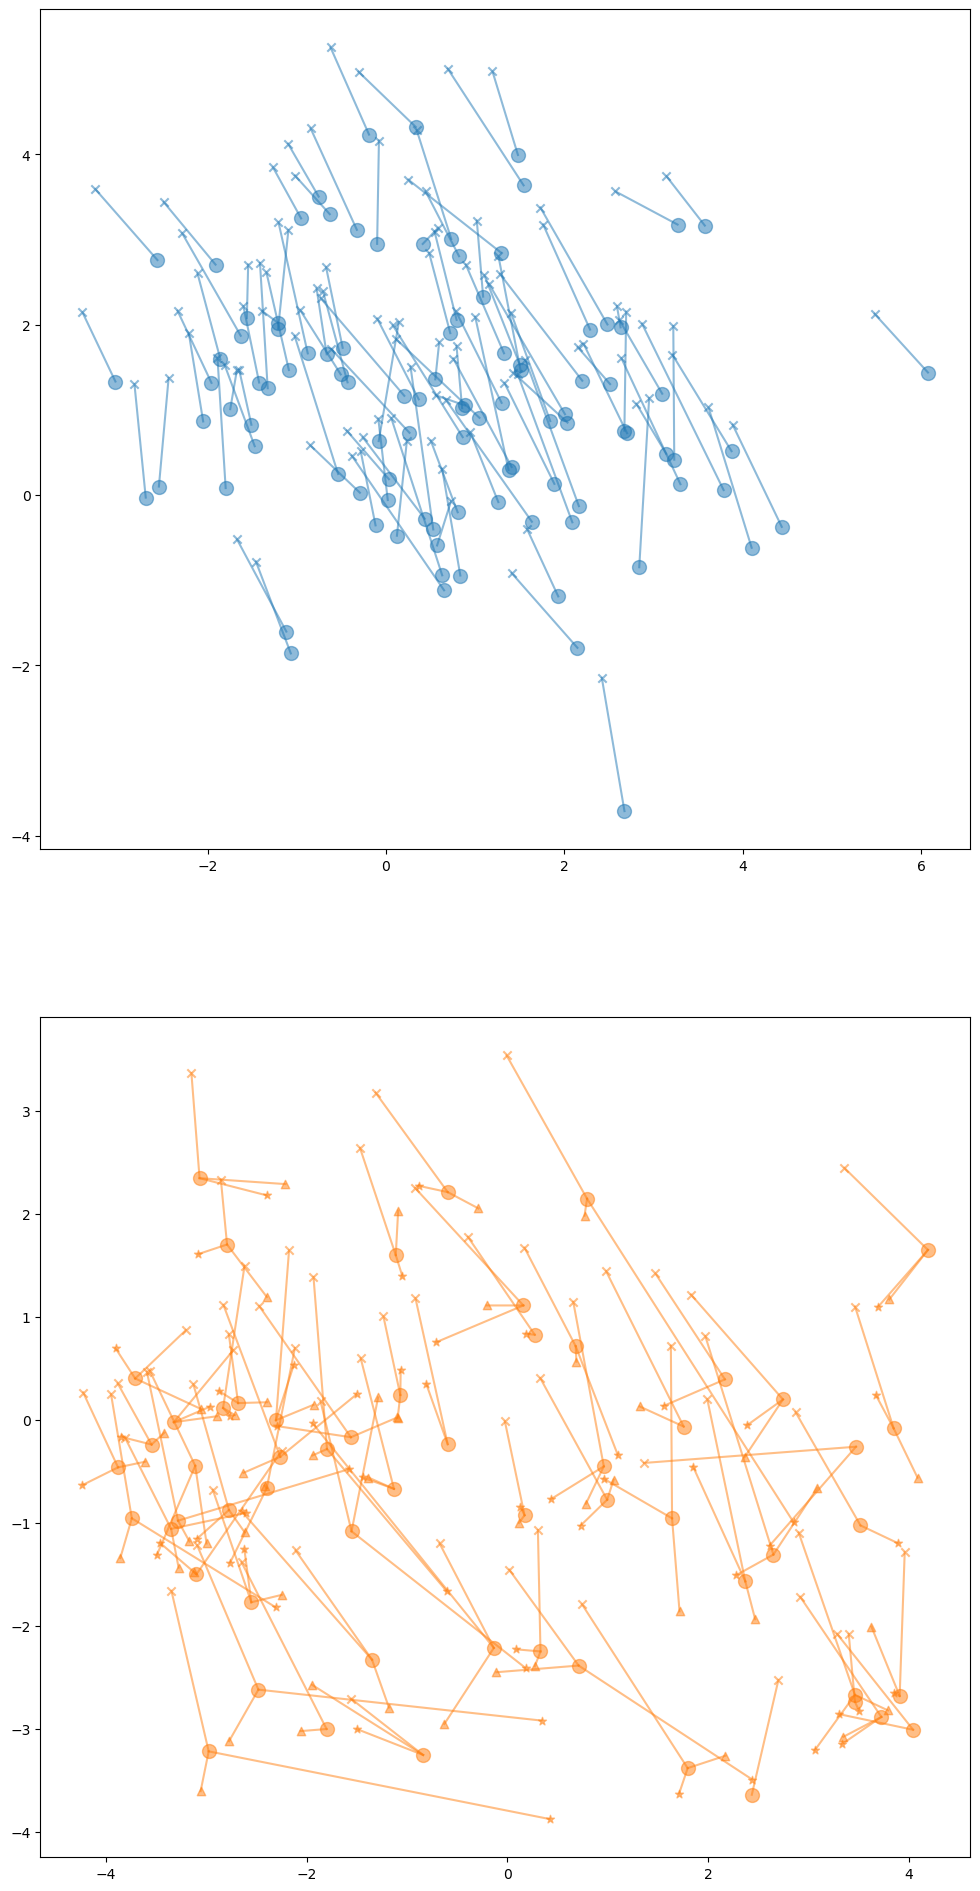

In [354]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Collect the vectors to be visualized
def draw(xs):
    xs = xs.drop_duplicates("base_from")
    xs = xs.sample(min(100, len(xs)))
    return xs
plot_words = rep_spec_df.query("correct").groupby("inflection").apply(draw)
plot_means = True

# Extract indices of relevant embeddings
all_indices = []
for _, row in plot_words.iterrows():
    base_idx = np.where(agg_src[:, 0] == state_space_spec.labels.index(row.base_from))[0]
    all_indices.extend(base_idx.tolist())

    if row.inflection == "NNS":
        nns_form = inflection_results_df.loc["NNS"].query("base == @row.base_from").inflected.iloc[0]
        nns_idx = np.where(agg_src[:, 0] == state_space_spec.labels.index(nns_form))[0]
        all_indices.extend(nns_idx.tolist())

    elif row.inflection == "VBZ":
        vbz_form = inflection_results_df.loc["VBZ"].query("base == @row.base_from").inflected.iloc[0]
        vbz_idx = np.where(agg_src[:, 0] == state_space_spec.labels.index(vbz_form))[0]
        all_indices.extend(vbz_idx.tolist())

        try:
            vbd_form = inflection_results_df.loc["VBD"].query("base == @row.base_from").inflected.iloc[0]
            vbd_idx = np.where(agg_src[:, 0] == state_space_spec.labels.index(vbd_form))[0]
            all_indices.extend(vbd_idx.tolist())
        except:
            pass

        try:
            vbg_form = inflection_results_df.loc["VBG"].query("base == @row.base_from").inflected.iloc[0]
            vbg_idx = np.where(agg_src[:, 0] == state_space_spec.labels.index(vbg_form))[0]
            all_indices.extend(vbg_idx.tolist())
        except:
            pass

# Ensure unique indices and extract embeddings
all_indices = np.unique(all_indices)
agg_centered = (agg - agg.mean(0)) / agg.std(0)
selected_vectors = agg_centered[all_indices]  # Use raw embeddings before PCA

# Run PCA on the selected embeddings
pca = PCA(n_components=2)
# pca.fit(agg_centered)
pca.fit(selected_vectors)
pca_transformed = pca.transform(selected_vectors)

# Map back to original indices
pca_dict = {idx: pca_transformed[i] for i, idx in enumerate(all_indices)}

# Set up plot
plot_inflections = sorted(plot_words.inflection.unique())
n_plot_inflections = len(plot_inflections)
f, axs = plt.subplots(figsize=(12, 12 * n_plot_inflections), nrows=n_plot_inflections)
# cmap = sns.color_palette("tab10", len(plot_words))
cmap = sns.color_palette("tab10", 2)
cmap = {i: cmap[0 if row.inflection == "NNS" else 1] for i, (_, row) in enumerate(plot_words.iterrows())}

max_plot_points = 20

# Plot points after PCA transformation
for i, (_, row) in enumerate(plot_words.iterrows()):
    ax = axs.flat[plot_inflections.index(row.inflection)]

    base_flat_idxs = np.where(agg_src[:, 0] == state_space_spec.labels.index(row.base_from))[0]
    base_reps = np.array([pca_dict[idx] for idx in base_flat_idxs if idx in pca_dict])
    if plot_means:
        base_reps = base_reps.mean(0, keepdims=True)
    if len(base_reps) > max_plot_points:
        base_reps = base_reps[np.random.choice(len(base_reps), size=max_plot_points, replace=False)]
    ax.scatter(*base_reps.T, color=cmap[i], label=row.base_from, alpha=0.5, s=100)

    if row.inflection == "NNS":
        nns_form = inflection_results_df.loc["NNS"].query("base == @row.base_from").inflected.iloc[0]
        inflected_flat_idxs = np.where(agg_src[:, 0] == state_space_spec.labels.index(nns_form))[0]
        inflected_reps = np.array([pca_dict[idx] for idx in inflected_flat_idxs if idx in pca_dict])
        if plot_means:
            inflected_reps = inflected_reps.mean(0, keepdims=True)
        if len(inflected_reps) > max_plot_points:
            inflected_reps = inflected_reps[np.random.choice(len(inflected_reps), size=max_plot_points, replace=False)]
        ax.scatter(*inflected_reps.T, color=cmap[i], marker="x", alpha=0.5)
        if plot_means: 
            # plot a link between base and here
            ax.plot([base_reps[0, 0], inflected_reps[0, 0]], [base_reps[0, 1], inflected_reps[0, 1]], color=cmap[i], alpha=0.5)

    elif row.inflection == "VBZ":
        vbz_form = inflection_results_df.loc["VBZ"].query("base == @row.base_from").inflected.iloc[0]
        inflected_flat_idxs = np.where(agg_src[:, 0] == state_space_spec.labels.index(vbz_form))[0]
        inflected_reps = np.array([pca_dict[idx] for idx in inflected_flat_idxs if idx in pca_dict])
        if plot_means:
            inflected_reps = inflected_reps.mean(0, keepdims=True)
        if len(inflected_reps) > max_plot_points:
            inflected_reps = inflected_reps[np.random.choice(len(inflected_reps), size=max_plot_points, replace=False)]
        ax.scatter(*inflected_reps.T, color=cmap[i], marker="x", alpha=0.5)
        if plot_means:
            # plot a link between base and here
            ax.plot([base_reps[0, 0], inflected_reps[0, 0]], [base_reps[0, 1], inflected_reps[0, 1]], color=cmap[i], alpha=0.5)

        try:
            vbd_form = inflection_results_df.loc["VBD"].query("base == @row.base_from").inflected.iloc[0]
            inflected_flat_idxs = np.where(agg_src[:, 0] == state_space_spec.labels.index(vbd_form))[0]
            inflected_reps = np.array([pca_dict[idx] for idx in inflected_flat_idxs if idx in pca_dict])
            if plot_means:
                inflected_reps = inflected_reps.mean(0, keepdims=True)
            if len(inflected_reps) > max_plot_points:
                inflected_reps = inflected_reps[np.random.choice(len(inflected_reps), size=max_plot_points, replace=False)]
            ax.scatter(*inflected_reps.T, color=cmap[i], marker="*", alpha=0.5)
            if plot_means:
                # plot a link between base and here
                ax.plot([base_reps[0, 0], inflected_reps[0, 0]], [base_reps[0, 1], inflected_reps[0, 1]], color=cmap[i], alpha=0.5)
        except: pass

        try:
            vbg_form = inflection_results_df.loc["VBG"].query("base == @row.base_from").inflected.iloc[0]
            inflected_flat_idxs = np.where(agg_src[:, 0] == state_space_spec.labels.index(vbg_form))[0]
            inflected_reps = np.array([pca_dict[idx] for idx in inflected_flat_idxs if idx in pca_dict])
            if plot_means:
                inflected_reps = inflected_reps.mean(0, keepdims=True)
            if len(inflected_reps) > max_plot_points:
                inflected_reps = inflected_reps[np.random.choice(len(inflected_reps), size=max_plot_points, replace=False)]
            ax.scatter(*inflected_reps.T, color=cmap[i], marker="^", alpha=0.5)
            if plot_means:
                # plot a link between base and here
                ax.plot([base_reps[0, 0], inflected_reps[0, 0]], [base_reps[0, 1], inflected_reps[0, 1]], color=cmap[i], alpha=0.5)
        except: pass